# GAN
## 目录
* autoencoder
* vae
* gan

source: https://github.com/L1aoXingyu/code-of-learn-deep-learning-with-pytorch

# 自动编码器
自动编码器最开始是作为一种数据压缩方法，同时还可以在卷积网络中进行逐层预训练，但是随后更多结构复杂的网络，比如 resnet 的出现使得我们能够训练任意深度的网络，自动编码器就不再使用在这个方面，下面我们讲一讲自动编码器的一个新的应用，这是随着生成对抗模型而出现的，就是使用自动编码器生成数据。

自动编码器的一般结构如下

![](https://ws1.sinaimg.cn/large/006tNc79ly1fmzr05igw3j30ni06j3z4.jpg)

由上面的图片，我们能够看到，第一部分是编码器(encoder)，第二部分是解码器(decoder)，编码器和解码器都可以是任意的模型，通常我们可以使用神经网络作为我们的编码器和解码器，输入的数据经过神经网络降维到一个编码，然后又通过另外一个神经网络解码得到一个与原始数据一模一样的生成数据，通过比较原始数据和生成数据，希望他们尽可能接近，所以最小化他们之间的差异来训练网络中编码器和解码器的参数。

当训练完成之后，我们如何生成数据呢？非常简单，我们只需要拿出解码器的部分，然后随机传入 code，就可以通过解码器生成各种各样的数据

![](https://ws3.sinaimg.cn/large/006tNc79ly1fmzrx3d3ygj30nu06ijs2.jpg)

In [1]:
import torch
from torch.autograd import Variable
from torch import nn
# 简单的自编码解码器
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3) # 输出的 code 是 3 维，便于可视化
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

##使用卷积网络
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # (b, 16, 10, 10)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # (b, 16, 5, 5)
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # (b, 8, 3, 3)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # (b, 8, 2, 2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # (b, 16, 5, 5)
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # (b, 8, 15, 15)
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # (b, 1, 28, 28)
            nn.Tanh()
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

In [6]:
#简单训练
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torchvision.utils import save_image
from torch.utils.data import DataLoader

im_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # 标准化
])

train_set = MNIST('/home/zlj/data/mnist', transform=im_tfs)
train_data = DataLoader(train_set, batch_size=128, shuffle=True)

#测试输出
#net = autoencoder()

conv_net = conv_autoencoder() #带卷积网络
if torch.cuda.is_available():
    conv_net = conv_net.cuda()

x = Variable(torch.randn(1, 28*28)) # batch size 是 1
code, _ = conv_net(x)
print(code.shape)

#定义损失函数和优化器
criterion = nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
#optimizer = torch.optim.Adam(conv_net.parameters(), lr=1e-3, weight_decay=1e-5)



def to_img(x):
    '''
    定义一个函数将最后的结果转换回图片
    '''
    x = 0.5 * (x + 1.)
    x = x.clamp(0, 1)
    x = x.view(x.shape[0], 1, 28, 28)
    return x

torch.Size([1, 3])


In [9]:
import time
import os
# 开始训练自动编码器
since = time.time()
for e in range(100):
    for im, _ in train_data:
        im = im.view(im.shape[0], -1)
        im = Variable(im)
        # 前向传播
        _, output = conv_net(im)
        loss = criterion(output, im) / im.shape[0] # 平均
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (e+1) % 20 == 0: # 每 20 次，将生成的图片保存一下
        print('epoch: {}, Loss: {:.4f}'.format(e + 1, loss.data[0]))
        pic = to_img(output.cpu().data)
        if not os.path.exists('./simple_autoencoder'):
            os.mkdir('./simple_autoencoder')
        save_image(pic, './simple_autoencoder/image_{}.png'.format(e + 1))
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

epoch: 20, Loss: 91.2643
epoch: 40, Loss: 99.6230
epoch: 60, Loss: 98.5777
epoch: 80, Loss: 96.4058
epoch: 100, Loss: 86.1791
Training complete in 20m 14s


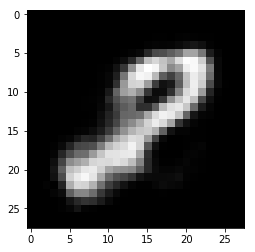

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
#随机给定一个code，看输出图像
code = Variable(torch.FloatTensor([[1.19, -3.36, 2.06]])) # 给一个 code 是 (1.19, -3.36, 2.06)
decode = net.decoder(code)
decode_img = to_img(decode).squeeze()
decode_img = decode_img.data.numpy() * 255
plt.imshow(decode_img.astype('uint8'), cmap='gray') # 生成图片 3

# 变分自动编码器
变分编码器是自动编码器的升级版本，其结构跟自动编码器是类似的，也由编码器和解码器构成。

回忆一下，自动编码器有个问题，就是并不能任意生成图片，因为我们没有办法自己去构造隐藏向量，需要通过一张图片输入编码我们才知道得到的隐含向量是什么，这时我们就可以通过变分自动编码器来解决这个问题。

其实原理特别简单，只需要在编码过程给它增加一些限制，迫使其生成的隐含向量能够粗略的遵循一个标准正态分布，这就是其与一般的自动编码器最大的不同。

这样我们生成一张新图片就很简单了，我们只需要给它一个标准正态分布的随机隐含向量，这样通过解码器就能够生成我们想要的图片，而不需要给它一张原始图片先编码。

一般来讲，我们通过 encoder 得到的隐含向量并不是一个标准的正态分布，为了衡量两种分布的相似程度，我们使用 KL divergence，利用其来表示隐含向量与标准正态分布之间差异的 loss，另外一个 loss 仍然使用生成图片与原图片的均方误差来表示。

KL divergence 的公式如下

$$
D{KL} (P || Q) =  \int_{-\infty}^{\infty} p(x) \log \frac{p(x)}{q(x)} dx
$$
## 重参数
为了避免计算 KL divergence 中的积分，我们使用重参数的技巧，不是每次产生一个隐含向量，而是生成两个向量，一个表示均值，一个表示标准差，这里我们默认编码之后的隐含向量服从一个正态分布的之后，就可以用一个标准正态分布先乘上标准差再加上均值来合成这个正态分布，最后 loss 就是希望这个生成的正态分布能够符合一个标准正态分布，也就是希望均值为 0，方差为 1

所以标准的变分自动编码器如下

![](https://ws4.sinaimg.cn/large/006tKfTcgy1fn15cq6n7pj30k007t0sv.jpg)
所以最后我们可以将我们的 loss 定义为下面的函数，由均方误差和 KL divergence 求和得到一个总的 loss

```
def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    MSE = reconstruction_function(recon_x, x)
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return MSE + KLD
```

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20) # mean
        self.fc22 = nn.Linear(400, 20) # var
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_()
        if torch.cuda.is_available():
            eps = Variable(eps.cuda())
        else:
            eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.tanh(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x) # 编码
        z = self.reparametrize(mu, logvar) # 重新参数化成正态分布
        return self.decode(z), mu, logvar # 解码，同时输出均值方差

net = VAE() # 实例化网络
if torch.cuda.is_available():
    net = net.cuda()

reconstruction_function = nn.MSELoss(size_average=False)

def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    MSE = reconstruction_function(recon_x, x)
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return MSE + KLD

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)